<img src='https://radiant-assets.s3-us-west-2.amazonaws.com/PrimaryRadiantMLHubLogo.png' alt='Radiant MLHub Logo' width='300'/>

# 2021 NASA Harvest Rwanda Baseline Model

This notebook walks you through the steps to create a baseline field delineation model for detecting boundaries from sentinel-2 time-series satellite imagery using a spatio-temporal U-Net model on the 2021 NASA Harvest dataset.

### Dependencies

All the dependencies for this notebook to run on colab are included in the `requirements_colab.txt` file included in this folder. To run the model on GPU you should go to edit/notebook settings and select GPU

In [2]:
!pip install -r 'https://raw.githubusercontent.com/pacomesimon/Nasa_harvest_field_boundary_proj/main/requirements_colab.txt'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached radiant_mlhub-0.4.1-py3-none-any.whl (36 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 497.6/497.6 MB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 29.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.1/301.1 kB 37.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.0/150.0 kB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 47.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.5/462.5 kB 52.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 90.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 90.9 MB/s eta 0:00:0

In [3]:
# Importing the needed libraries
import getpass
import glob
import keras
import os
import pickle
import random
import shutil
from radiant_mlhub import Dataset

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio as rio

import tensorflow as tf
import segmentation_models as sm

from pathlib import Path
from radiant_mlhub import Dataset
from random import choice
from segmentation_models import Unet
from scipy.ndimage import gaussian_filter
from sklearn.model_selection import train_test_split


from keras import backend as K
from keras.layers import *
from keras.models import *
from keras.models import load_model
from keras.optimizers import *
from keras.preprocessing import image

from tensorflow.keras.layers import *
from tensorflow.keras.losses import *

from sklearn.model_selection import train_test_split

from typing import List, Any, Callable, Tuple

Segmentation Models: using `keras` framework.


In [4]:
tf.config.list_physical_devices("GPU") #activate GPU resource for model training

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
dataset_id = 'nasa_rwanda_field_boundary_competition'
assets = ['labels']

In [6]:
#Append your MLHUB_API_KEY after this cell is executed to download dataset
os.environ['MLHUB_API_KEY'] =  getpass.getpass(prompt="MLHub API Key: ")
dataset = Dataset.fetch(dataset_id)

MLHub API Key: ··········


In [7]:
dataset.download(output_dir = dataset_id, if_exists='overwrite')

  0%|          | 0/0.4 [00:00<?, ?M/s]

  0%|          | 0/112.5 [00:00<?, ?M/s]

  0%|          | 0/25.5 [00:00<?, ?M/s]

[PosixPath('/content/nasa_rwanda_field_boundary_competition/nasa_rwanda_field_boundary_competition_labels_train.tar.gz'),
 PosixPath('/content/nasa_rwanda_field_boundary_competition/nasa_rwanda_field_boundary_competition_source_train.tar.gz'),
 PosixPath('/content/nasa_rwanda_field_boundary_competition/nasa_rwanda_field_boundary_competition_source_test.tar.gz')]

In [8]:
archives = ['source_train', 'source_test', 'labels_train']

In [9]:
for archive in archives:
  full_path = f"{dataset_id}/{dataset_id}_{archive}.tar.gz"
  shutil.unpack_archive(full_path, dataset_id)

In [10]:
#image snapshot dimensions
IMG_WIDTH = 256 
IMG_HEIGHT = 256 
IMG_CHANNELS = 4 #we have the rgba bands

We have two sets of data: the train and test dataset, each having a list of file ids belonging to them.
For model development purposes, we will use the training set(`train_tiles`) and use the test set for model prediction/evaluation.

In [11]:
train_source_items = f"{dataset_id}/{dataset_id}_source_train"
train_label_items = f"{dataset_id}/{dataset_id}_labels_train"

In [12]:
next(os.walk(train_source_items))[1][0]

'nasa_rwanda_field_boundary_competition_source_train_05_2021_11'

In [13]:
def clean_string(s: str) -> str:
    """
    extract the tile id and timestamp from a source image folder
    e.g extract 'ID_YYYY_MM' from 'nasa_rwanda_field_boundary_competition_source_train_ID_YYYY_MM'
    """
    s = s.replace(f"{dataset_id}_source_", '').split('_')[1:]
    return '_'.join(s)

In [14]:
train_tiles = [clean_string(s) for s in next(os.walk(train_source_items))[1]]

In [15]:
# train_tiles

Our source images have pixel values > 255, hence we need to apply normalisation on our images to generate a normalised image. We apply the min-max normalisation for this which is simply: $${\text{all pixel values - minimum pixel value} \over \text{maximum pixel value - minimum pixel value}}$$

In [16]:
def normalize(
    array: np.ndarray
):
    """ normalise image to give a meaningful output """
    array_min, array_max = array.min(), array.max()
    return (array - array_min) / (array_max - array_min)

### Feature Selection

In this section, we select features to use.

In [17]:
train_tiles = [i for i in train_tiles if i[-1]=="8"] # here, we select only the images taken in August, the 8th month of the year.

### Feature Engineering Functions

In this section, we are going to define functions that will be used to engineer new features. Those functions include the ones that will create new multispectral indices.

In [18]:
indices_list_all = ['ARI', 'ARI2', 'ARVI', 'AVI', 'BAI', 'BAIM', 'BCC', 'BITM', 
                'BIXS', 'BNDVI', 'BWDRVI', 'CIG', 'CIRE', 'CVI', 'DSWI4', 
                'GBNDVI', 'GCC', 'GEMI', 'GLI', 'GNDVI', 'GOSAVI', 'GRNDVI', 
                'GRVI', 'IKAW', 'IPVI', 'MCARI1', 'MCARI2', 'MGRVI', 'MRBVI', 
                'MSAVI', 'MSR', 'MTVI1', 'MTVI2', 'NDDI', 'NDTI', 'NDWI', 
                'NDWIns', 'NDGlaI', 'NDSII', 'NDVI', 'NDYI', 'NGRDI', 'NIRv', 
                'NLI', 'NormG', 'NormNIR', 'NormR', 'OCVI', 'OSAVI', 'PISI', 
                'RCC', 'RDVI', 'RGBVI', 'RGRI', 'RI', 'RI4XS', 'SEVI', 'SI', 
                'SR', 'SR2', 'TDVI', 'TGI', 'TriVI', 'TVI', 'VARI', 'VIG', 
                'VgNIRBI', 'VrNIRBI', 'WDRVI']
# indices_list = indices_list_all.copy()
indices_list = [i for i in indices_list_all 
                if not(i in ['GEMI',  'RGRI',  'BAIM',  # this will remove the indices that did not visibly give reasonable outcomes after passing through Sobel highpass filters
                             'MSR',  'BAI',  'DSWI4',  
                             'OCVI',  'CVI',  'GRVI',  
                             'SR2',  'CIG',  'NDDI',  
                             'ARI',  'RI4XS',  'ARI2',  
                             'VARI',  'CIRE',  'SR',  
                             'SEVI']
                )
]

In [19]:
def indices_functions(indices_list,R):
  alpha=1
  cexp=1
  gamma=1
  RE1= R
  fdelta =1
  S2= R
  indices = {
  "ARI": lambda R,G,B,N :      (1 / G) - (1 / RE1),
  "ARI2": lambda R,G,B,N :      N * ((1 / G) - (1 / RE1)),
  "ARVI": lambda R,G,B,N :      (N - (R - gamma * (R - B))) / (N + (R - gamma * (R - B))),
  "AVI": lambda R,G,B,N :      (N * (1.0 - R) * (N - R)) ** (1/3),
  "BAI": lambda R,G,B,N :      1.0 / ((0.1 - R) ** 2.0 + (0.06 - N) ** 2.0),
  "BAIM": lambda R,G,B,N :      1.0/((0.05 - N) ** 2.0) + ((0.2 - S2) ** 2.0),
  "BCC": lambda R,G,B,N :      B / (R + G + B),
  "BITM": lambda R,G,B,N :      (((B**2.0)+(G**2.0)+(R**2.0))/3.0)**0.5,
  "BIXS": lambda R,G,B,N :      (((G**2.0)+(R**2.0))/2.0)**0.5,
  "BNDVI": lambda R,G,B,N :      (N - B)/(N + B),
  "BWDRVI": lambda R,G,B,N :      (alpha * N - B) / (alpha * N + B),
  "CIG": lambda R,G,B,N :      (N / G) - 1.0,
  "CIRE": lambda R,G,B,N :      (N / RE1) - 1,
  "CVI": lambda R,G,B,N :      (N * R) / (G ** 2.0),
  "DSWI4": lambda R,G,B,N :      G/R,
  "GBNDVI": lambda R,G,B,N :      (N - (G + B))/(N + (G + B)),
  "GCC": lambda R,G,B,N :      G / (R + G + B),
  "GEMI": lambda R,G,B,N :      ((2.0*((N ** 2.0)-(R ** 2.0)) + 1.5*N + 0.5*R)/(N + R + 0.5))*(1.0 - 0.25*((2.0 * ((N ** 2.0) - (R ** 2)) + 1.5 * N + 0.5 * R)/(N + R + 0.5)))-((R - 0.125)/(1 - R)),
  "GLI": lambda R,G,B,N :      (2.0 * G - R - B) / (2.0 * G + R + B),
  "GNDVI": lambda R,G,B,N :      (N - G)/(N + G),
  "GOSAVI": lambda R,G,B,N :      (N - G) / (N + G + 0.16),
  "GRNDVI": lambda R,G,B,N :      (N - (G + R))/(N + (G + R)),
  "GRVI": lambda R,G,B,N :      N/G,
  "IKAW": lambda R,G,B,N :      (R - B)/(R + B),
  "IPVI": lambda R,G,B,N :      N/(N + R),
  "MCARI1": lambda R,G,B,N :      1.2 * (2.5 * (N - R) - 1.3 * (N - G)),
  "MCARI2": lambda R,G,B,N :      (1.5 * (2.5 * (N - R) - 1.3 * (N - G))) / ((((2.0 * N + 1) ** 2) - (6.0 * N - 5 * (R ** 0.5)) - 0.5) ** 0.5),
  "MGRVI": lambda R,G,B,N :      (G ** 2.0 - R ** 2.0) / (G ** 2.0 + R ** 2.0),
  "MRBVI": lambda R,G,B,N :      (R ** 2.0 - B ** 2.0)/(R ** 2.0 + B ** 2.0),
  "MSAVI": lambda R,G,B,N :      0.5 * (2.0 * N + 1 - (((2 * N + 1) ** 2) - 8 * (N - R)) ** 0.5),
  "MSR": lambda R,G,B,N :      (N / R - 1) / ((N / R + 1) ** 0.5),
  "MTVI1": lambda R,G,B,N :      1.2 * (1.2 * (N - G) - 2.5 * (R - G)),
  "MTVI2": lambda R,G,B,N :      (1.5 * (1.2 * (N - G) - 2.5 * (R - G))) / ((((2.0 * N + 1) ** 2) - (6.0 * N - 5 * (R ** 0.5)) - 0.5) ** 0.5),
  "NDDI": lambda R,G,B,N :      (((N - R)/(N + R)) - ((G - N)/(G + N)))/(((N - R)/(N + R)) + ((G - N)/(G + N))),
  "NDTI": lambda R,G,B,N :      (R-G)/(R+G),
  "NDWI": lambda R,G,B,N :      (G - N) / (G + N),
  "NDWIns": lambda R,G,B,N :      (G - alpha * N)/(G + N),
  "NDGlaI": lambda R,G,B,N :      (G - R)/(G + R),
  "NDSII": lambda R,G,B,N :      (G - N)/(G + N),
  "NDVI": lambda R,G,B,N :      (N - R)/(N + R),
  "NDYI": lambda R,G,B,N :      (G - B) / (G + B),
  "NGRDI": lambda R,G,B,N :      (G - R) / (G + R),
  "NIRv": lambda R,G,B,N :      ((N - R) / (N + R)) * N,
  "NLI": lambda R,G,B,N :      ((N ** 2) - R)/((N ** 2) + R),
  "NormG": lambda R,G,B,N :      G/(N + G + R),
  "NormNIR": lambda R,G,B,N :      N/(N + G + R),
  "NormR": lambda R,G,B,N :      R/(N + G + R),
  "OCVI": lambda R,G,B,N :      (N / G) * (R / G) ** cexp,
  "OSAVI": lambda R,G,B,N :      (N - R) / (N + R + 0.16),
  "PISI": lambda R,G,B,N :      0.8192 * B - 0.5735 * N + 0.0750,
  "RCC": lambda R,G,B,N :      R / (R + G + B),
  "RDVI": lambda R,G,B,N :      (N - R) / ((N + R) ** 0.5),
  "RGBVI": lambda R,G,B,N :      (G ** 2.0 - B * R)/(G ** 2.0 + B * R),
  "RGRI": lambda R,G,B,N :      R/G,
  "RI": lambda R,G,B,N :      (R - G)/(R + G),
  "RI4XS": lambda R,G,B,N :      (R**2.0)/(G**4.0),
  "SEVI": lambda R,G,B,N :      (N/R) + fdelta * (1.0/R),
  "SI": lambda R,G,B,N :      ((1.0 - B) * (1.0 - G) * (1.0 - R)) ** (1/3),
  "SR": lambda R,G,B,N :      N/R,
  "SR2": lambda R,G,B,N :      N/G,
  "TDVI": lambda R,G,B,N :      1.5 * ((N - R)/((N ** 2.0 + R + 0.5) ** 0.5)),
  "TGI": lambda R,G,B,N :      - 0.5 * (190 * (R - G) - 120 * (R - B)),
  "TriVI": lambda R,G,B,N :      0.5 * (120 * (N - G) - 200 * (R - G)),
  "TVI": lambda R,G,B,N :      (((N - R)/(N + R)) + 0.5) ** 0.5,
  "VARI": lambda R,G,B,N :      (G - R) / (G + R - B),
  "VIG": lambda R,G,B,N :      (G - R) / (G + R),
  "VgNIRBI": lambda R,G,B,N :      (G - N)/(G + N),
  "VrNIRBI": lambda R,G,B,N :      (R - N)/(R + N),
  "WDRVI": lambda R,G,B,N :      (alpha * N - R) / (alpha * N + R),
  }
  return {item:value for (item,value) in indices.items() if item in indices_list}


In [20]:
def image_histogram_equalization(image, number_bins=256):
    # from http://www.janeriksolem.net/histogram-equalization-with-python-and.html

    # get image histogram
    image_histogram, bins = np.histogram(image.flatten(), number_bins, density=True)
    cdf = image_histogram.cumsum() # cumulative distribution function
    cdf = (number_bins-1) * cdf / cdf[-1] # normalize

    # use linear interpolation of cdf to find new pixel values
    image_equalized = np.interp(image.flatten(), bins[:-1], cdf)

    return image_equalized.reshape(image.shape)/number_bins #, cdf

In [21]:
def feature_engineer(field,indices_list,post_processing=False,do_pca=False):
  R = field[:,:,1]
  G = field[:,:,2]
  B = field[:,:,3]
  N = field[:,:,0]
  
  R = (image_histogram_equalization(R))
  G = (image_histogram_equalization(G))
  B = (image_histogram_equalization(B))
  N = (image_histogram_equalization(N))

  indices = indices_functions(indices_list,R)
  indexes = {item:value(R,G,B,N) for (item,value) in indices.items()}
  new_field = np.dstack(
      tuple(indexes.values())
    )

  def norm_ft(array: np.ndarray):
    """ normalise image to give a meaningful output """
    a=array[~np.isnan(array) & ~(array==np.inf)].copy()
    if(not(a.size==0)):
      array_min, array_max = a.min(), a.max()
      array = np.nan_to_num(array, nan=a.min(), posinf=a.max(), neginf=a.min())
      array=(array - array_min) / (array_max - array_min)
      return np.nan_to_num(array, nan=0, posinf=1, neginf=0)
    else:
      array = np.nan_to_num(array, nan=0, posinf=1, neginf=0)
      return array 

  
  def dev_img(field):
    rows, cols, features = field.shape
    if post_processing:
      for c in range(features):
        field[:, :, c]=norm_ft(field[:, :, c])
        # field[:, :, c]=sobel(field[:, :, c])
        # field[:, :, c]=((field[:, :, c]-field[:, :, c].mean())**2)
    else:
      for c in range(features):
        field[:, :, c]=norm_ft(field[:, :, c])
    return field

  if do_pca:
    return pca_engineer(dev_img(new_field))
  return dev_img(new_field)


In [22]:
def entry_flattener(field,mask):
  rows, cols, features = field.shape
  X = np.ones((rows*cols,features))
  for c in range(features):
    X[:,c]=(field[:, :, c].flatten())
  if (mask is None):
    Y = None
  else:
    Y = mask.flatten()
  return X,Y

In [24]:
pca_dims_file = open("pca_dims.obj", 'rb') 
pca_dims = pickle.load(pca_dims_file)
def pca_engineer(field):
  X,Y=entry_flattener(field,None)
  X = pca_dims.transform(X)
  X_pcas=[]
  for i in range(X.shape[1]):
    X_pcas.append(X[:,i].reshape(IMG_WIDTH,IMG_HEIGHT))
  return np.dstack(tuple(X_pcas))

In [25]:
pca_dims

PCA(n_components=10)

### Data Augmentation

In this notebook, we will perform data augmentation on our normalised images. This will be used to populate the model with data to obtain even more accurate results.

We will employ the following data augmentation techniques on the dataset:
- rotation, flipping, blurring.

These techniques were thanks to the radix-ai GitHub repository, which can be accessed [here](https://github.com/radix-ai/agoro-field-boundary-detector).
We will observe the results on a random source image and its associated label below:

In [26]:
#loading the 4 bands of the image
tile = random.choice(train_tiles)
print(tile)
bd1 = rio.open(f"{train_source_items}/{dataset_id}_source_train_{tile}/B01.tif")
bd1_array = bd1.read(1)
bd2 = rio.open(f"{train_source_items}/{dataset_id}_source_train_{tile}/B02.tif")
bd2_array = bd2.read(1)
bd3 = rio.open(f"{train_source_items}/{dataset_id}_source_train_{tile}/B03.tif")
bd3_array = bd3.read(1)
bd4 = rio.open(f"{train_source_items}/{dataset_id}_source_train_{tile}/B04.tif")
bd4_array = bd4.read(1)
b01_norm = normalize(bd1_array)
b02_norm = normalize(bd2_array)
b03_norm = normalize(bd3_array)
b04_norm = normalize(bd4_array)

field = np.dstack((b04_norm, b03_norm, b02_norm, b01_norm))
mask  = rio.open(Path.cwd() / f"{train_label_items}/{dataset_id}_labels_train_{tile.split('_')[0]}/raster_labels.tif").read(1)

12_2021_08


In [27]:
#https://github.com/radix-ai/agoro-field-boundary-detector/tree/master/src/agoro_field_boundary_detector
def t_linear(
    field: np.ndarray,
    mask: np.ndarray,
    _: int = 0,
) -> Tuple[np.ndarray, np.ndarray]:
    """Apply a linear (i.e. no) transformation and save."""
    return field, mask

def t_rotation(
    field: np.ndarray,
    mask: np.ndarray,
    rot: int,
) -> Tuple[np.ndarray, np.ndarray]:
    """Rotate the data."""
    assert rot in range(0, 3 + 1)
    for _ in range(rot):
        field = np.rot90(field)
        mask = np.rot90(mask)
    return field, mask

def t_flip(
    field: np.ndarray,
    mask: np.ndarray,
    idx: int,
) -> Tuple[np.ndarray, np.ndarray]:
    """Flip the data."""
    assert idx in range(0, 2 + 1)
    if idx == 0:  # Diagonal
        field = np.rot90(np.fliplr(field))
        mask = np.rot90(np.fliplr(mask))
    if idx == 1:  # Horizontal
        field = np.flip(field, axis=0)
        mask = np.flip(mask, axis=0)
    if idx == 2:  # Vertical
        field = np.flip(field, axis=1)
        mask = np.flip(mask, axis=1)
    return field, mask

def t_blur(
    field: np.ndarray,
    mask: np.ndarray,
    sigma: int,
) -> Tuple[np.ndarray, np.ndarray]:
    """Blur the image by applying a Gaussian filter."""
    assert 0 <= sigma <= 10
    sigma_f = 1.0 + (sigma / 10)
    field = np.copy(field)
    for i in range(3):
        field[:, :, i] = gaussian_filter(field[:, :, i], sigma=sigma_f)
    return field, mask

In [28]:
def show_image(field:np.ndarray, mask:np.ndarray): 
    """Show the field and corresponding mask."""
    fig = plt.figure(figsize=(8,6))
    ax1 = fig.add_subplot(121)  # left side
    ax2 = fig.add_subplot(122)  # right side
    ax1.imshow(field[:,:,1:4])  # rgb band
    plt.gray()
    ax2.imshow(mask)
    plt.tight_layout()
    plt.show()

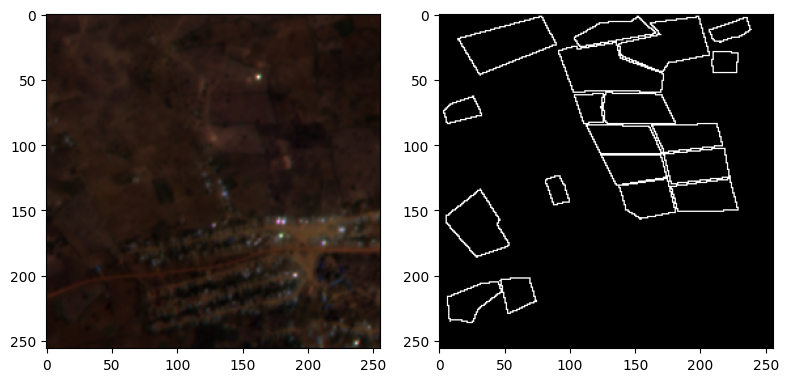

In [29]:
show_image(field, mask)

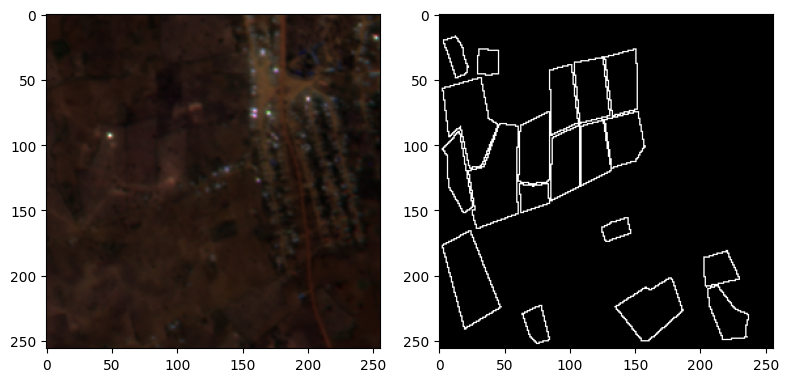

In [30]:
f,m = t_rotation(field, mask, rot=1) #rotation
show_image(f,m)

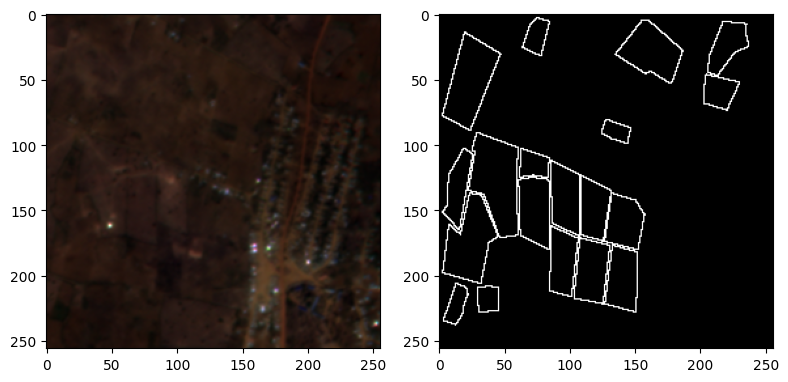

In [31]:
f,m = t_flip(field, mask, idx=0) #flipping
show_image(f,m)

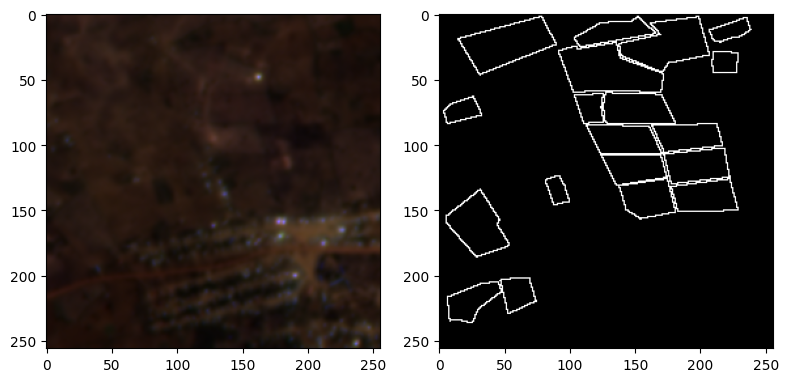

In [32]:
f,m = t_blur(field, mask, sigma=5) #blur
show_image(f,m)

In [33]:
def generate(
    field: np.ndarray,
    mask: np.ndarray,
    write_folder: Path,
    prefix: str = "",
) -> None:
    """
    Generate data augmentations of the provided field and corresponding mask which includes:
     - Linear (no) transformation
     - Rotation
     - Horizontal or vertical flip
     - Gaussian filter (blur)
    :param field: Input array of the field to augment
    :param mask: Input array of the corresponding mask to augment
    :param write_folder: Folder (path) to write the results (augmentations) to
    :param prefix: Field-specific prefix used when writing the augmentation results
    """
    # Generate transformations
    f, m = [0,1,2,3], [0,1,2,3] #dummy data. will be replaced
    f[0],m[0] = t_linear(field, mask) #no augmentation
    f[1],m[1] = t_rotation(field, mask, rot=1) #rotation
    f[2],m[2] = t_flip(field, mask, idx=0) #flipping
    f[3],m[3] = t_blur(field, mask, sigma=5) #blur
    for i in range(len(f)):        
        with open(write_folder +'/'+ f"fields/{str(prefix).zfill(2)}_{i}.pkl", 'wb') as handle:
            pickle.dump(f[i], handle, protocol=pickle.HIGHEST_PROTOCOL)

        with open(write_folder +'/'+ f"masks/{str(prefix).zfill(2)}_{i}.pkl", 'wb') as handle:
            pickle.dump(m[i], handle, protocol=pickle.HIGHEST_PROTOCOL)

In [34]:
def main(
    field: List[np.ndarray],
    mask: List[np.ndarray],
    prefix: List[str],
    write_folder: Path,
) -> None:
    """
    Generate and save data augmentations for all the fields and corresponding masks with the following:
     - Linear (no) transformation
     - Rotation
     - Horizontal or vertical flip
     - Gaussian filter (blur)
     - Gamma filter (brightness)
    :param fields: Fields to augment
    :param masks: Corresponding masks to augment
    :param prefixes: Field-specific prefixes corresponding each field
    :param write_folder: Path to write the results (augmentations) to
    """
    generate(
        field=field,
        mask=mask,
        prefix=prefix,
        write_folder=write_folder,
    )

In [36]:
#apply augmentation effects to training set
for tile in train_tiles:
    bd1 = rio.open(f"{train_source_items}/{dataset_id}_source_train_{tile}/B01.tif")
    bd1_array = bd1.read(1)
    bd2 = rio.open(f"{train_source_items}/{dataset_id}_source_train_{tile}/B02.tif")
    bd2_array = bd2.read(1)
    bd3 = rio.open(f"{train_source_items}/{dataset_id}_source_train_{tile}/B03.tif")
    bd3_array = bd3.read(1)
    bd4 = rio.open(f"{train_source_items}/{dataset_id}_source_train_{tile}/B04.tif")
    bd4_array = bd4.read(1)
    b01_norm = normalize(bd1_array)
    b02_norm = normalize(bd2_array)
    b03_norm = normalize(bd3_array)
    b04_norm = normalize(bd4_array)

    ids_list  = tile.split('_') # XX_YYYY_MM where XX is the training file id and YYYY_MM is the timestamp
    tile_id   = ids_list[0]
    timestamp = f"{ids_list[1]}_{ids_list[2]}"

    field = np.dstack((b04_norm, b03_norm, b02_norm, b01_norm))
    field = feature_engineer(field,indices_list,do_pca=True)
    mask  = rio.open(Path.cwd() / f"{train_label_items}/{dataset_id}_labels_train_{tile_id}/raster_labels.tif").read(1) 

    #create a folder for the augmented images
    if not os.path.isdir(f"./augmented_data/{timestamp}"):
        os.makedirs(f"./augmented_data/{timestamp}")
    if not os.path.isdir(f"./augmented_data/{timestamp}/fields"):
        os.makedirs(f"./augmented_data/{timestamp}/fields")
    if not os.path.isdir(f"./augmented_data/{timestamp}/masks"):
        os.makedirs(f"./augmented_data/{timestamp}/masks")

    main( #applying augmentation effects
        field  = field,
        mask   = mask,
        prefix = tile_id,
        write_folder = f"./augmented_data/{timestamp}"
    ) #approximately 30 seconds

<ipython-input-19-8695b630ed23>:12: RuntimeWarning: invalid value encountered in power
  "AVI": lambda R,G,B,N :      (N * (1.0 - R) * (N - R)) ** (1/3),
<ipython-input-19-8695b630ed23>:72: RuntimeWarning: invalid value encountered in sqrt
  "TVI": lambda R,G,B,N :      (((N - R)/(N + R)) + 0.5) ** 0.5,
<ipython-input-19-8695b630ed23>:12: RuntimeWarning: invalid value encountered in power
  "AVI": lambda R,G,B,N :      (N * (1.0 - R) * (N - R)) ** (1/3),
<ipython-input-19-8695b630ed23>:72: RuntimeWarning: invalid value encountered in sqrt
  "TVI": lambda R,G,B,N :      (((N - R)/(N + R)) + 0.5) ** 0.5,
<ipython-input-19-8695b630ed23>:12: RuntimeWarning: invalid value encountered in power
  "AVI": lambda R,G,B,N :      (N * (1.0 - R) * (N - R)) ** (1/3),
<ipython-input-19-8695b630ed23>:72: RuntimeWarning: invalid value encountered in sqrt
  "TVI": lambda R,G,B,N :      (((N - R)/(N + R)) + 0.5) ** 0.5,
<ipython-input-19-8695b630ed23>:12: RuntimeWarning: invalid value encountered in powe

In [37]:
IMG_CHANNELS=10# len(indices_list)

In [38]:
timestamps = next(os.walk(f"./augmented_data"))[1] #Get all timestamps
augmented_files = next(os.walk(f"./augmented_data/{timestamps[0]}/fields"))[2] #Get all augmented tile ids. can just use one timestamp
X = np.empty((len(augmented_files), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS*len(timestamps)), dtype=np.float32) #time-series image
y = np.empty((len(augmented_files), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.uint8) #mask for each scene
i = 0
for file in augmented_files:
    idx = 0
    augmented_id = file.split('.pkl')[0] #id without .pkl extension
    temporal_fields = []
    for timestamp in timestamps:
        with open(f"./augmented_data/{timestamp}/fields/{augmented_id}.pkl", 'rb') as field:
            field = pickle.load(field) 
        X[i][:,:,idx:idx+IMG_CHANNELS] = field
        idx += IMG_CHANNELS
    with open(f"./augmented_data/{timestamp}/masks/{augmented_id}.pkl", 'rb') as mask:
        mask = pickle.load(mask)
    y[i] = mask.reshape(IMG_HEIGHT, IMG_WIDTH, 1)
    i+=1

In [39]:
X.shape

(228, 256, 256, 10)

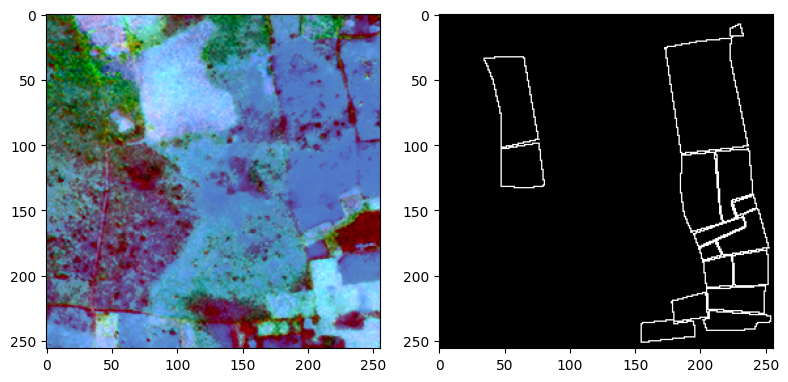

In [41]:
random.randint(0, len(augmented_files)) #sanity check
random_image = random.randint(0, len(augmented_files)-1)
show_image(X[random_image][:,:,0:4], y[random_image].reshape(IMG_WIDTH, IMG_HEIGHT))

In [42]:
X_0 = X.copy()

In [47]:
np.sum(X_0==X) # 149422080

149422080

In [48]:
np.max(X_0-X),np.min(X_0-X)

(0.0, 0.0)

### Model Training

We decided to use U-Net as it has shown impressive results over multiple domains in image segmentation.
We will employ a ResNet34 backbone with our spatio-temporal U-Net model.

This uses our 24 channels (6 timestamps * 4 bands per timestamp) and generates the predicted field boundary per scene.

We will also use an 80:20 train:validation set split for model training.

Since this is a binary segmentation problem (field boundary or no field boundary), we will use the `binary cross_entropy` loss.

In [45]:
BACKBONE = 'seresnet18'
preprocess_input = sm.get_preprocessing(BACKBONE)

In [46]:
X = preprocess_input(X)

In [49]:
#https://github.com/sustainlab-group/ParcelDelineation/blob/master/models/unet.py
def unet(pretrained_weights = None,input_size = (256,256,4)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(input = inputs, output = conv10)

    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return 

In [50]:
def learning_rate_scheduler(epoch):
    lr = 1e-4
    '''
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 150:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    '''
    print("Set Learning Rate : {}".format(lr))
    return lr

In [51]:
num_channels = IMG_CHANNELS*len(timestamps) #24
input_shape = (256,256,num_channels)
batch_size = 4

For the model, we will make use of two key metrics: **Recall** and **F1-score**.

**Recall** evaluates how much of the field boundaries which were labelled were actually predicted as well while the **f1-score** combines the precision and recall by evaluating the harmonic mean.

**NOTE** that the recall is the more important metric for this case as we are mostly concerned about the retrieved field boundaries out of the labelled field boundaries.

In [52]:
#https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model
def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall
def f1(y_true, y_pred):
    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall_   = recall(y_true, y_pred)
    return 2*((precision*recall_)/(precision+recall_+K.epsilon()))
def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

In [53]:
sm.set_framework('tf.keras')
sm.framework()
model = None 
model_unet = Unet(BACKBONE, encoder_weights='imagenet')
new_model = keras.models.Sequential()
new_model.add(Conv2D(3, (1,1), padding='same', activation='relu', input_shape=input_shape))
new_model.add(model_unet)
model = new_model 
#sm.metrics.FScore(beta=1)
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_scheduler(0)),
              metrics=[precision,recall,f1,"accuracy"])

45367296/45351256 [==============================] - 2s 0us/step
Set Learning Rate : 0.0001


In [54]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 256, 256, 3)       33        
                                                                 
 model_1 (Functional)        (None, None, None, 1)     14429650  
                                                                 
Total params: 14,429,683
Trainable params: 14,419,757
Non-trainable params: 9,926
_________________________________________________________________


In [55]:
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [56]:
tf.config.experimental_run_functions_eagerly(True)

Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


In [57]:
history = model.fit(x=x_train, y=y_train,
              validation_data=(x_val, y_val),
              steps_per_epoch = len(x_train)//batch_size,
              validation_steps = len(x_val)//batch_size,
              batch_size=batch_size, epochs=200)

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/200
45/45 [==============================] - 21s 219ms/step - loss: 0.5422 - precision: 0.0714 - recall: 0.2107 - f1: 0.0962 - accuracy: 0.7973 - val_loss: 0.9523 - val_precision: 0.0545 - val_recall: 0.4299 - val_f1: 0.0963 - val_accuracy: 0.6335
Epoch 2/200
45/45 [==============================] - 12s 231ms/step - loss: 0.3419 - precision: 0.0942 - recall: 0.0137 - f1: 0.0217 - accuracy: 0.9399 - val_loss: 0.4654 - val_precision: 0.0331 - val_recall: 0.0047 - val_f1: 0.0082 - val_accuracy: 0.9480
Epoch 3/200
45/45 [==============================] - 11s 249ms/step - loss: 0.2655 - precision: 0.0864 - recall: 0.0027 - f1: 0.0050 - accuracy: 0.9456 - val_loss: 0.3781 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_accuracy: 0.9543
Epoch 4/200
45/45 [==============================] - 11s 242ms/step - loss: 0.2412 - precision: 0.0846 - recall: 0.0016 - f1: 0.0031 - accuracy: 0.9453 - val_loss: 0.2840 - val_precision: 0.0000e+00 - val_recall: 0.0000e

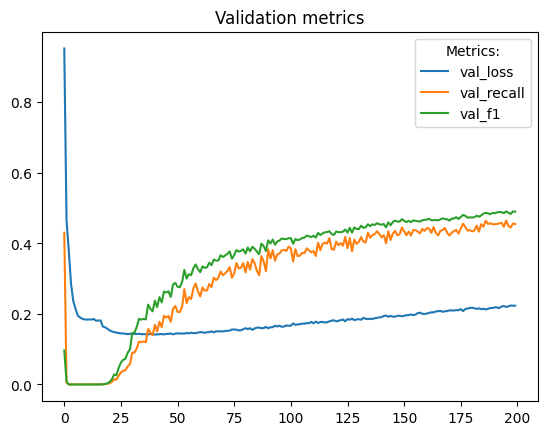

In [58]:
metrics_table=pd.DataFrame(history.history)
def plot_metric(metric):
  plt.plot(metrics_table.index, metrics_table[metric],label=metric)
plt.figure()
plot_metric("val_loss")
plot_metric("val_recall")
plot_metric("val_f1")
plt.title("Validation metrics")
plt.legend(title='Metrics:')
plt.show()

In [59]:
pd.DataFrame(history.history).to_csv(f"{BACKBONE}_batchsize_{batch_size}_PCA.csv")

In [75]:
BACKBONE

'seresnet18'

In [60]:
model.save(f"./unet_model.h5")

In [61]:
model = load_model(f"./unet_model.h5", custom_objects ={"recall":sm.metrics.Recall(threshold=0.5), "f1": f1,"precision":precision})

### Viewing the predictions

In [62]:
def view_preds(i):
    i = int(i % len(x_val))
    model_pred = model.predict(np.expand_dims(x_val[i], 0))
    model_pred = model_pred[0]
    model_pred = (model_pred >= 0.5).astype(np.uint8)
    model_pred = model_pred.reshape(IMG_HEIGHT, IMG_WIDTH)
    fig = plt.figure(figsize=(8,6))
    ax1 = fig.add_subplot(121)  # left side
    ax2 = fig.add_subplot(122)  # right side
    ax1.imshow(model_pred) # predicted mask
    ax1.set_title("Predicted Mask")
    plt.gray()
    ax2.imshow(y_val[i]) # the real mask
    ax2.set_title("Real Mask")
    plt.tight_layout()
    plt.show()

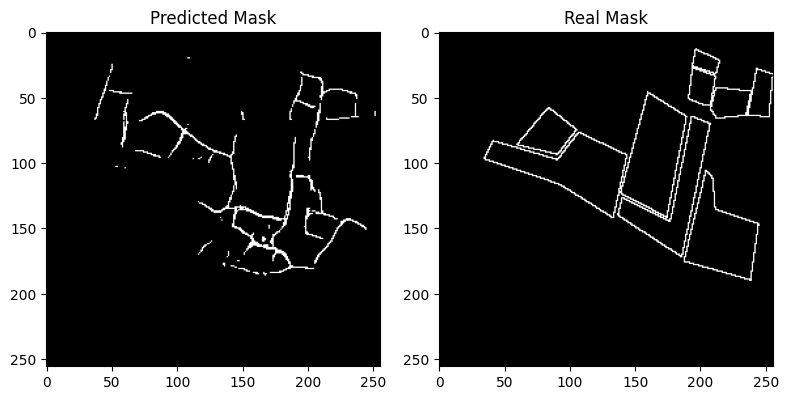

In [64]:
view_preds(4)

### Loading test chips to run predictions

In [65]:
test_source_items = f"{dataset_id}/{dataset_id}_source_test"
test_tiles = [clean_string(s) for s in next(os.walk(test_source_items))[1]]

In [66]:
test_tile_ids = set()
for tile in test_tiles:
    test_tile_ids.add(tile.split('_')[0])

In [67]:
X_test = np.empty((len(test_tile_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS*len(timestamps)), dtype=np.float32)
i = 0
loaded_tiles = []
for tile_id in test_tile_ids:
    idx = 0
    for timestamp in timestamps:
        bd1 = rio.open(f"{test_source_items}/{dataset_id}_source_test_{tile_id}_{timestamp}/B01.tif")
        bd1_array = bd1.read(1)
        bd2 = rio.open(f"{test_source_items}/{dataset_id}_source_test_{tile_id}_{timestamp}/B02.tif")
        bd2_array = bd2.read(1)
        bd3 = rio.open(f"{test_source_items}/{dataset_id}_source_test_{tile_id}_{timestamp}/B03.tif")
        bd3_array = bd3.read(1)
        bd4 = rio.open(f"{test_source_items}/{dataset_id}_source_test_{tile_id}_{timestamp}/B04.tif")
        bd4_array = bd4.read(1)
        b01_norm = normalize(bd1_array)
        b02_norm = normalize(bd2_array)
        b03_norm = normalize(bd3_array)
        b04_norm = normalize(bd4_array)
        
        field = np.dstack((b04_norm, b03_norm, b02_norm, b01_norm))
        field = feature_engineer(field,indices_list,do_pca=True)
        X_test[i][:,:,idx:idx+IMG_CHANNELS] = field
        idx+=IMG_CHANNELS
    loaded_tiles.append(str(tile_id).zfill(2)) #track order test tiles are loaded into X to make sure tile id matches 
    i+=1

<ipython-input-19-8695b630ed23>:12: RuntimeWarning: invalid value encountered in power
  "AVI": lambda R,G,B,N :      (N * (1.0 - R) * (N - R)) ** (1/3),
<ipython-input-19-8695b630ed23>:72: RuntimeWarning: invalid value encountered in sqrt
  "TVI": lambda R,G,B,N :      (((N - R)/(N + R)) + 0.5) ** 0.5,
<ipython-input-19-8695b630ed23>:12: RuntimeWarning: invalid value encountered in power
  "AVI": lambda R,G,B,N :      (N * (1.0 - R) * (N - R)) ** (1/3),
<ipython-input-19-8695b630ed23>:72: RuntimeWarning: invalid value encountered in sqrt
  "TVI": lambda R,G,B,N :      (((N - R)/(N + R)) + 0.5) ** 0.5,
<ipython-input-19-8695b630ed23>:12: RuntimeWarning: invalid value encountered in power
  "AVI": lambda R,G,B,N :      (N * (1.0 - R) * (N - R)) ** (1/3),
<ipython-input-19-8695b630ed23>:72: RuntimeWarning: invalid value encountered in sqrt
  "TVI": lambda R,G,B,N :      (((N - R)/(N + R)) + 0.5) ** 0.5,
<ipython-input-19-8695b630ed23>:12: RuntimeWarning: invalid value encountered in powe

In [70]:
X_test = preprocess_input(X_test)

In [71]:
predictions_dictionary = {}
for i in range(len(test_tile_ids)):
    model_pred = model.predict(np.expand_dims(X_test[i], 0))
    model_pred = model_pred[0]
    model_pred = (model_pred >= 0.5).astype(np.uint8)
    model_pred = model_pred.reshape(IMG_HEIGHT, IMG_WIDTH)
    predictions_dictionary.update([(str(loaded_tiles[i]), pd.DataFrame(model_pred))])

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


In [72]:
dfs = []
for key, value in predictions_dictionary.items():
    ftd = value.unstack().reset_index().rename(columns={'level_0': 'row', 'level_1': 'column', 0: 'label'})
    ftd['tile_row_column'] = f'Tile{key}_' + ftd['row'].astype(str) + '_' + ftd['column'].astype(str)
    ftd = ftd[['tile_row_column', 'label']]
    dfs.append(ftd)

sub = pd.concat(dfs)
sub

,tile_row_column,label
0,Tile01_0_0,0
1,Tile01_0_1,0
2,Tile01_0_2,0
3,Tile01_0_3,0
4,Tile01_0_4,0
...,...,...
65531,Tile11_255_251,0
65532,Tile11_255_252,0
65533,Tile11_255_253,0
65534,Tile11_255_254,0


In [73]:
sub.to_csv(f"./harvest_sample_submission.csv", index = False)

In [74]:
!ls -l | grep harvest_sample_submission

-rw-r--r-- 1 root root  13751318 May  2 13:19 harvest_sample_submission.csv
